**Refer to the `./README.md` file for citations and additional details.**

## Aboveground biomass - NorESM-LSP/CLM/FATES output vs. VCG observations

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import pandas as pd  # Tabular data handling
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import urllib.request  
import shutil
import zipfile

#### Download and load model data

In [2]:
# If not already there, download zipped results from zenodo
model_zip_path = Path("./model_data/results.zip")
model_unzip_path = Path("./model_data/results")

model_data_url = "https://zenodo.org/api/files/659fb5bf-771f-4f72-a870-7c4d36b2dc09/NorESM-LSP_technical_results.zip"

if not model_zip_path.is_file():
    print("Downloading zip file...", end="")
    with urllib.request.urlopen(model_data_url) as response, open(model_zip_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print("done.")
    
# Unzip
if not model_unzip_path.is_dir() and model_zip_path.is_file():
    print("Unzipping...", end="")
    with zipfile.ZipFile(model_zip_path, 'r') as temp_zip:
        temp_zip.extractall(model_unzip_path)
    print("done.")

In [5]:
# Define paths to concatenated model output NetCDFs
defaultpft_model_output_path = Path("./model_data/results/NorESM-LSP_technical_results/bor1-1000y-allpfts.h0.0001-1001.nc")
grasspft_model_output_path = Path("./model_data/results/NorESM-LSP_technical_results/bor1-1000y-grasspfts.h0.0001-1001.nc")

In [6]:
# Load netcdf data
start_time = time.time()

defaultpft_model_out_data = xr.open_mfdataset(defaultpft_model_output_path, decode_times=True)
grasspft_model_out_data =  xr.open_mfdataset(grasspft_model_output_path, decode_times=True)

print(f"--- Time it took to read the data: {round(float(time.time() - start_time), 3)} seconds ---")

--- Time it took to read the data: 4.708 seconds ---


#### Download and load observation data

In [7]:
# Site name in observational dataset
site_name_vcg = "Fauske"

In [8]:
# Read biomass data
biomass_csv_path = Path("./observation_data/biomass.csv")

# If not already there, download the files
if not biomass_csv_path.is_file():
    with urllib.request.urlopen("https://osf.io/download/hbx6z/") as response, open(biomass_csv_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

#### Read observation data

In [9]:
vcg_biomass_df = pd.read_csv(Path(f"{biomass_csv_path}"), low_memory=False)

In [10]:
# Explore biomass DataFrame
print(vcg_biomass_df.shape)
print(vcg_biomass_df.dtypes)
vcg_biomass_df.head()

(5412, 14)
year                     int64
date                    object
round                  float64
siteID                  object
temperature_level       object
precipitation_level      int64
blockID                 object
plotID                  object
treatment               object
removed_fg              object
biomass                float64
name                    object
remark                  object
functional_group        object
dtype: object


year date  round      siteID temperature_level  precipitation_level  \
0  2015  NaN    1.0  Arhelleren            boreal                    3   
1  2015  NaN    1.0  Arhelleren            boreal                    3   
2  2015  NaN    1.0  Arhelleren            boreal                    3   
3  2015  NaN    1.0  Arhelleren            boreal                    3   
4  2015  NaN    1.0  Arhelleren            boreal                    3   

  blockID   plotID treatment removed_fg  biomass name  \
0    Arh1  Arh1FGB       FGB          F      4.2  NaN   
1    Arh1  Arh1FGB       FGB          B      3.4  NaN   
2    Arh1  Arh1FGB       FGB          G      8.6  NaN   
3    Arh1   Arh1FG        GF          F      8.2  NaN   
4    Arh1   Arh1FG        GF          G      4.3  NaN   

                                              remark functional_group  
0  Only one round of removals was executed this year              NaN  
1                                                NaN              NaN  
2                                                NaN              NaN  
3                                                NaN              NaN  
4                                                NaN              NaN

#### Plot layout and save path settings

In [11]:
# Define folder for saving plots
plot_save_path = Path("./output_plots/")

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

In [12]:
# Set general plotting options
cm = 1/2.54  # centimeters in inches
DPI = 100
FIG_SIZE_CM = (9.5*cm, 7*cm)
TICK_LABEL_FONT_SIZE = 9
AX_LABEL_FONT_SIZE = 11

---
## Observations
Subset to the BOR1 site. Only use the initial removal (total biomass decreases for repeated removals over time) from the plots were both graminoids and forbs were removed (i.e. excluding bryophytes to compare to grass PFTs).

In [13]:
bor1_biomass_df = vcg_biomass_df[(vcg_biomass_df["siteID"] == site_name_vcg) &
                                 (((vcg_biomass_df["treatment"] == "FGB") & (vcg_biomass_df["year"] == 2015)) |  # Control plot, all plants removed
                                  ((vcg_biomass_df["treatment"] == "GF") & (vcg_biomass_df["year"] == 2015)))  # Graminoids and forbs removed
                                ].reset_index(drop=True)
# Explore
print(f"Shape: {bor1_biomass_df.shape}")
print(f"Data types:\n{bor1_biomass_df.dtypes}")
bor1_biomass_df

Shape: (20, 14)
Data types:
year                     int64
date                    object
round                  float64
siteID                  object
temperature_level       object
precipitation_level      int64
blockID                 object
plotID                  object
treatment               object
removed_fg              object
biomass                float64
name                    object
remark                  object
functional_group        object
dtype: object


year        date  round  siteID temperature_level  precipitation_level  \
0   2015  2015-07-22    1.0  Fauske            boreal                    1   
1   2015  2015-07-22    1.0  Fauske            boreal                    1   
2   2015  2015-07-22    1.0  Fauske            boreal                    1   
3   2015  2015-07-22    1.0  Fauske            boreal                    1   
4   2015  2015-07-22    1.0  Fauske            boreal                    1   
5   2015  2015-07-22    1.0  Fauske            boreal                    1   
6   2015  2015-07-22    1.0  Fauske            boreal                    1   
7   2015  2015-07-22    1.0  Fauske            boreal                    1   
8   2015  2015-07-22    1.0  Fauske            boreal                    1   
9   2015  2015-07-22    1.0  Fauske            boreal                    1   
10  2015  2015-07-22    1.0  Fauske            boreal                    1   
11  2015  2015-07-22    1.0  Fauske            boreal                    1   
12  2015  2015-07-22    1.0  Fauske            boreal                    1   
13  2015  2015-07-22    1.0  Fauske            boreal                    1   
14  2015  2015-07-22    1.0  Fauske            boreal                    1   
15  2015  2015-07-22    1.0  Fauske            boreal                    1   
16  2015  2015-07-22    1.0  Fauske            boreal                    1   
17  2015  2015-07-22    1.0  Fauske            boreal                    1   
18  2015  2015-07-22    1.0  Fauske            boreal                    1   
19  2015  2015-07-22    1.0  Fauske            boreal                    1   

   blockID   plotID treatment removed_fg  biomass name remark functional_group  
0     Fau1  Fau1FGB       FGB          F     9.78  NaN    NaN              NaN  
1     Fau1  Fau1FGB       FGB          B     6.24  NaN    NaN              NaN  
2     Fau1  Fau1FGB       FGB          G     9.63  NaN    NaN              NaN  
3     Fau1   Fau1FG        GF          F     8.95  NaN    NaN              NaN  
4     Fau1   Fau1FG        GF          G    14.61  NaN    NaN              NaN  
5     Fau2  Fau2FGB       FGB          F    11.02  NaN    NaN              NaN  
6     Fau2  Fau2FGB       FGB          B     0.17  NaN    NaN              NaN  
7     Fau2  Fau2FGB       FGB          G    14.07  NaN    NaN              NaN  
8     Fau2   Fau2FG        GF          F    10.77  NaN    NaN              NaN  
9     Fau2   Fau2FG        GF          G     6.42  NaN    NaN              NaN  
10    Fau5  Fau5FGB       FGB          F     8.64  NaN    NaN              NaN  
11    Fau5  Fau5FGB       FGB          B     0.04  NaN    NaN              NaN  
12    Fau5  Fau5FGB       FGB          G    15.03  NaN    NaN              NaN  
13    Fau5   Fau5FG        GF          F    14.82  NaN    NaN              NaN  
14    Fau5   Fau5FG        GF          G     5.86  NaN    NaN              NaN  
15    Fau4  Fau4FGB       FGB          F    13.08  NaN    NaN              NaN  
16    Fau4  Fau4FGB       FGB          B     2.25  NaN    NaN              NaN  
17    Fau4  Fau4FGB       FGB          G     7.70  NaN    NaN              NaN  
18    Fau4   Fau4FG        GF          F     2.96  NaN    NaN              NaN  
19    Fau4   Fau4FG        GF          G     5.05  NaN    NaN              NaN

In [14]:
# Make sure no NA values present in important columns
bor1_biomass_df.isna().sum()

year                    0
date                    0
round                   0
siteID                  0
temperature_level       0
precipitation_level     0
blockID                 0
plotID                  0
treatment               0
removed_fg              0
biomass                 0
name                   20
remark                 20
functional_group       20
dtype: int64

### Convert to kg/m2

In [15]:
bor1_biomass_kg_m2_df = bor1_biomass_df.copy()
# 25cm*25cm (0.0625 m2) plots to 1m2 (0.0625 * 16 = 1), g to kg (1 g = 0.001 kg)
bor1_biomass_kg_m2_df['biomass'] = bor1_biomass_kg_m2_df['biomass'] * 16 / 1000
bor1_biomass_kg_m2_df

year        date  round  siteID temperature_level  precipitation_level  \
0   2015  2015-07-22    1.0  Fauske            boreal                    1   
1   2015  2015-07-22    1.0  Fauske            boreal                    1   
2   2015  2015-07-22    1.0  Fauske            boreal                    1   
3   2015  2015-07-22    1.0  Fauske            boreal                    1   
4   2015  2015-07-22    1.0  Fauske            boreal                    1   
5   2015  2015-07-22    1.0  Fauske            boreal                    1   
6   2015  2015-07-22    1.0  Fauske            boreal                    1   
7   2015  2015-07-22    1.0  Fauske            boreal                    1   
8   2015  2015-07-22    1.0  Fauske            boreal                    1   
9   2015  2015-07-22    1.0  Fauske            boreal                    1   
10  2015  2015-07-22    1.0  Fauske            boreal                    1   
11  2015  2015-07-22    1.0  Fauske            boreal                    1   
12  2015  2015-07-22    1.0  Fauske            boreal                    1   
13  2015  2015-07-22    1.0  Fauske            boreal                    1   
14  2015  2015-07-22    1.0  Fauske            boreal                    1   
15  2015  2015-07-22    1.0  Fauske            boreal                    1   
16  2015  2015-07-22    1.0  Fauske            boreal                    1   
17  2015  2015-07-22    1.0  Fauske            boreal                    1   
18  2015  2015-07-22    1.0  Fauske            boreal                    1   
19  2015  2015-07-22    1.0  Fauske            boreal                    1   

   blockID   plotID treatment removed_fg  biomass name remark functional_group  
0     Fau1  Fau1FGB       FGB          F  0.15648  NaN    NaN              NaN  
1     Fau1  Fau1FGB       FGB          B  0.09984  NaN    NaN              NaN  
2     Fau1  Fau1FGB       FGB          G  0.15408  NaN    NaN              NaN  
3     Fau1   Fau1FG        GF          F  0.14320  NaN    NaN              NaN  
4     Fau1   Fau1FG        GF          G  0.23376  NaN    NaN              NaN  
5     Fau2  Fau2FGB       FGB          F  0.17632  NaN    NaN              NaN  
6     Fau2  Fau2FGB       FGB          B  0.00272  NaN    NaN              NaN  
7     Fau2  Fau2FGB       FGB          G  0.22512  NaN    NaN              NaN  
8     Fau2   Fau2FG        GF          F  0.17232  NaN    NaN              NaN  
9     Fau2   Fau2FG        GF          G  0.10272  NaN    NaN              NaN  
10    Fau5  Fau5FGB       FGB          F  0.13824  NaN    NaN              NaN  
11    Fau5  Fau5FGB       FGB          B  0.00064  NaN    NaN              NaN  
12    Fau5  Fau5FGB       FGB          G  0.24048  NaN    NaN              NaN  
13    Fau5   Fau5FG        GF          F  0.23712  NaN    NaN              NaN  
14    Fau5   Fau5FG        GF          G  0.09376  NaN    NaN              NaN  
15    Fau4  Fau4FGB       FGB          F  0.20928  NaN    NaN              NaN  
16    Fau4  Fau4FGB       FGB          B  0.03600  NaN    NaN              NaN  
17    Fau4  Fau4FGB       FGB          G  0.12320  NaN    NaN              NaN  
18    Fau4   Fau4FG        GF          F  0.04736  NaN    NaN              NaN  
19    Fau4   Fau4FG        GF          G  0.08080  NaN    NaN              NaN

In [16]:
# How many samples taken at what date?
bor1_biomass_kg_m2_df['date'].value_counts()

2015-07-22    20
Name: date, dtype: int64

---
## Modelled above ground biomass

In [17]:
defaultpft_model_out_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 156,
                                       fates_levcacls: 2, fates_levcapf: 24,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 12, fates_levfuel: 6,
                                       ...
                                       fates_levscagpf: 1092,
                                       fates_levagepft: 84,
                                       fates_levagefuel: 42, time: 12000,
                                       hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/14)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levpft                      (fates_levpft) int32 1 2 3 4 ... 10 11 12
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * time                              (time) object 0001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, hist_interval, lndgrid,
                                fates_levelem, fates_levelcwd, glc_nec, ltype
Data variables: (12/497)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(12000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Sep 19 15:15:55 2022: ncrcat ./...
    source:                               Community Terre

In [18]:
grasspft_model_out_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 26,
                                       fates_levcacls: 2, fates_levcapf: 4,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 2, fates_levfuel: 6,
                                       ...
                                       fates_levscagpf: 182,
                                       fates_levagepft: 14,
                                       fates_levagefuel: 42, time: 12000,
                                       hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/14)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levpft                      (fates_levpft) int32 1 2
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * time                              (time) object 0001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, hist_interval, lndgrid,
                                fates_levelem, fates_levelcwd, glc_nec, ltype
Data variables: (12/497)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(12000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Thu Sep 22 12:30:53 2022: ncrcat ./...
    source:                               Community Terrestrial Systems Model
    

### Plot modelled PFT level aboveground biomass

In [19]:
modelled_defaultpft_agb = defaultpft_model_out_data['FATES_VEGC_ABOVEGROUND_SZPF']
modelled_grasspft_agb = grasspft_model_out_data['FATES_VEGC_ABOVEGROUND_SZPF']

# Load the mask showing which sizeclass/pft index belongs to which PFT number
pft_indices_by_size_class = defaultpft_model_out_data["fates_pftmap_levscpf"]

In [20]:
# Calculate monthly sums of aboveground biomass per PFT
modelled_defaultpft_agb_monthly = modelled_defaultpft_agb.resample(time='1M').mean(keep_attrs=True)
modelled_grasspft_agb_monthly = modelled_grasspft_agb.resample(time='1M').mean(keep_attrs=True)

In [22]:
# Quick visualization of the biomass data structure - aboveground biomass per pft in each sizeclass
modelled_defaultpft_agb_monthly#.plot()

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND_SZPF' (time: 12000,
                                                 fates_levscpf: 156, lndgrid: 1)>
dask.array<stack, shape=(12000, 156, 1), dtype=float32, chunksize=(1, 156, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-28 00:00:00 ... 1001-01-31 00:00:00
Dimensions without coordinates: fates_levscpf, lndgrid
Attributes:
    long_name:      aboveground biomass by pft/size in kg carbon per m2
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

In [23]:
# Quick visualization of the biomass data structure - aboveground biomass per pft in each sizeclass
modelled_grasspft_agb_monthly#.plot()

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND_SZPF' (time: 12000,
                                                 fates_levscpf: 26, lndgrid: 1)>
dask.array<stack, shape=(12000, 26, 1), dtype=float32, chunksize=(1, 26, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-28 00:00:00 ... 1001-01-31 00:00:00
Dimensions without coordinates: fates_levscpf, lndgrid
Attributes:
    long_name:      aboveground biomass by pft/size in kg carbon per m2
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

In [24]:
modelled_defaultpft_agb_monthly_df = pd.DataFrame(
    index=range(len(modelled_defaultpft_agb_monthly.indexes['time'])),
    columns=defaultpft_model_out_data.fates_levpft.values
)
modelled_defaultpft_agb_monthly_df

1    2    3    4    5    6    7    8    9    10   11   12
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
11995  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11996  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11998  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11999  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[12000 rows x 12 columns]

In [25]:
modelled_grasspft_agb_monthly_df = pd.DataFrame(
    index=range(len(modelled_grasspft_agb_monthly.indexes['time'])),
    columns=defaultpft_model_out_data.fates_levpft.values
)
modelled_defaultpft_agb_monthly_df

1    2    3    4    5    6    7    8    9    10   11   12
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
11995  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11996  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11998  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
11999  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[12000 rows x 12 columns]

**Populate the DataFrame**

_Naive solution, xarray's inbuilt functions probably include a more clever way to speed up the process._

In [26]:
# Subset variables to decrease run time
pft_size_class_indices = defaultpft_model_out_data['fates_pftmap_levscpf']
total_iterations = modelled_defaultpft_agb_monthly_df.shape[0]
pft_indices = defaultpft_model_out_data['fates_levpft'].values
monthly_values = modelled_defaultpft_agb_monthly.values

# Loop through the DataArray, one month per iteration
for row_idx, cur_month_agb in enumerate(monthly_values):
    
    # Loop through the PFT indices
    for cur_pft_idx in pft_indices:
        
        # Sum up total modelled respective PFT values for current month
        modelled_defaultpft_agb_monthly_df.loc[row_idx, cur_pft_idx] = \
        float(sum(cur_month_agb[pft_size_class_indices == cur_pft_idx]))
        
    # Print progress
    print(f"Step: {row_idx+1}/{total_iterations}", end='\r')

In [27]:
# Subset variables to decrease run time
pft_size_class_indices = grasspft_model_out_data['fates_pftmap_levscpf']
total_iterations = modelled_grasspft_agb_monthly_df.shape[0]
pft_indices = grasspft_model_out_data['fates_levpft'].values
monthly_values = modelled_grasspft_agb_monthly.values

# Loop through the DataArray, one month per iteration
for row_idx, cur_month_agb in enumerate(monthly_values):
    
    # Loop through the PFT indices
    for cur_pft_idx in pft_indices:
        
        # Sum up total modelled respective PFT values for current month
        modelled_grasspft_agb_monthly_df.loc[row_idx, cur_pft_idx] = \
        float(sum(cur_month_agb[pft_size_class_indices == cur_pft_idx]))
        
    # Print progress
    print(f"Step: {row_idx+1}/{total_iterations}", end='\r')

In [28]:
modelled_defaultpft_agb_monthly_df

1          2         3         4         5         6         7   \
0      0.007739   0.008811  0.007381  0.008766   0.00782  0.007405  0.002439   
1       0.00583   0.008639   0.00642  0.008514  0.006051  0.006447  0.002341   
2      0.004594   0.008874  0.006102  0.008738  0.005045  0.006129  0.002338   
3      0.003848   0.009748  0.005743   0.00969  0.004691   0.00577  0.002584   
4      0.003943   0.011902  0.005723  0.012108  0.005706  0.006022  0.003293   
...         ...        ...       ...       ...       ...       ...       ...   
11995       0.0    11.4367       0.0       0.0       0.0       0.0       0.0   
11996       0.0  11.491404       0.0       0.0       0.0       0.0       0.0   
11997       0.0  11.504982       0.0       0.0       0.0       0.0       0.0   
11998       0.0  11.482094       0.0       0.0       0.0       0.0       0.0   
11999       0.0  11.441262       0.0       0.0       0.0       0.0       0.0   

             8         9         10        11        12  
0      0.002313  0.001992  0.000044  0.000055   0.00005  
1      0.001908  0.001678  0.000035  0.000051  0.000037  
2      0.001898  0.001575  0.000033  0.000049  0.000028  
3      0.002216  0.001462   0.00003  0.000049  0.000021  
4      0.003496  0.001525  0.000033  0.000091  0.000029  
...         ...       ...       ...       ...       ...  
11995       0.0       0.0       0.0       0.0       0.0  
11996       0.0       0.0       0.0       0.0       0.0  
11997       0.0       0.0       0.0       0.0       0.0  
11998       0.0       0.0       0.0       0.0       0.0  
11999       0.0       0.0       0.0       0.0       0.0  

[12000 rows x 12 columns]

In [29]:
# Load PFT dictionary
pft_dict_json_path = Path('../model_output_analysis/dicts/default_fates_pfts.json')

with open(pft_dict_json_path, 'r', encoding='utf-8') as fates_pft_json:
    fates_pft_dict = json.load(fates_pft_json)

If you change the included PFTs in FATES, they will be renamed/reindexed starting from 1 up to the number of PFTs you include. We will manually map the PFT index number to the corresponding entry in the full list for the "only grass" simulation again.

In [30]:
modelled_grasspft_agb_monthly_df = modelled_grasspft_agb_monthly_df.dropna(axis=1, how='all')
modelled_grasspft_agb_monthly_df.columns = [int(key) for key, val in fates_pft_dict.items() if val['long_name'] in ('Arctic C3 grass', 'Cool C3 grass')]
modelled_grasspft_agb_monthly_df

10        11
0      0.000044  0.000055
1      0.000035  0.000051
2      0.000033  0.000048
3       0.00003  0.000047
4      0.000032  0.000084
...         ...       ...
11995  0.031413  1.350527
11996  0.030135  1.360695
11997  0.028152  1.273892
11998   0.02754  1.247252
11999  0.026793  1.182597

[12000 rows x 2 columns]

#### Plot

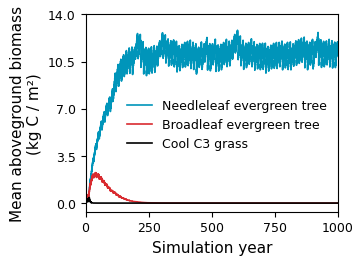

In [33]:
fig, ax = plt.subplots(figsize=FIG_SIZE_CM, dpi=DPI)
# Discard PFTs that never exceed threshold value (in kg C m-2 month-1)
biomass_threshold = 0.3
# Number of years to plot
plot_n_years = 1000
# Line width in plot
line_width = 1.2

# Custom colors, based on colorblind friendly ESRI color ramp "Circling circus"
allpfts_colors = [
    "#0095ba",  # Blueish
    "#d92b30",  # Red
    '#000000',  # Black
]
idx = 0

# Loop through full PFT list
for col in modelled_defaultpft_agb_monthly_df.columns:
    
    # Plot allpft simulation PFT biomass, line for each PFT that exceeds biomass threshold
    if any([(x > biomass_threshold) for x in modelled_defaultpft_agb_monthly_df[col]]):
        
        # Remove 'extratropical' from PFT names for readability
        cur_label = fates_pft_dict[str(col)]['long_name']
        cur_label = cur_label.split(" ")
        cur_label = " ".join([x for x in cur_label if x != 'extratropical'])

        ax.plot(
            modelled_defaultpft_agb_monthly_df.loc[0:plot_n_years*12, col],
            label=cur_label,
            color=allpfts_colors[idx],
            linewidth=line_width
        )
        # Increment color list index
        idx += 1

# Set x-axis limits
ax.set_xlim([0, plot_n_years*12])
# Reduce to five labels
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
# Convert monthly labels to years
ax.set_xticks(
    ax.get_xticks(), 
    [str(int(x/12)) for x in ax.get_xticks()]
)

# Change tick label size
ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE)

ax.set_ylabel("Mean aboveground biomass\n(kg C / m²)", fontsize=AX_LABEL_FONT_SIZE)
ax.set_xlabel("Simulation year", fontsize=AX_LABEL_FONT_SIZE)

# Add legend
ax.legend(
    bbox_to_anchor=(1, 0.44),
    loc='center right',
    fontsize=TICK_LABEL_FONT_SIZE,
    frameon=False
)

# Number of y-ticks
max_y = max(ax.get_yticks())
ax.set_yticks([0, max_y*(1/4), max_y*(2/4), max_y*(3/4), max_y])

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/agb_over_time_allpft_grasspft.png", format='png')

## Extract last 10 simulation years, compare to observations
To compare the modelled aboveground biomass to the observations, we need to harmonize the different data formats. The 1000 year simulations repeatedly cycle 10 years of GSWP3 climate forcing (from 2004 to 2014); based on the plot above, we will assume that the PFT biomasses have reached an equilibrium state at the end of the simulation period. We will thus use the range of the last 10 years and subset the summer months when the FunCaB data collection took place.

As there is no grass PFT biomass at the end of the simulation with all PFTs included, we will focus on the run where we only allowed two grass PFTs to grow (note: without any land management).

The FunCaB dataset provides the dry weight of the respective plant functional groups in grams for each of the 25x25 cm plots, while the model calculates biomass in kgC/m2. FATES includes an adjustable parameter, `fates_c2b`, the `Carbon to biomass multiplier of bulk structural tissue`, which we will use for the conversion. The default value for each PFT is `fates_c2b=2`.

In [32]:
modelled_agb_dated_monthly_df = modelled_grasspft_agb_monthly_df.copy()

# Convert dates to python datetimes
modelled_agb_dated_monthly_df.index = [
    dt.datetime(int(year), int(month), 1) for year, month in zip(
        modelled_grasspft_agb_monthly['time.year'], modelled_grasspft_agb_monthly['time.month']
    )
]

# Use long PFT names as column names
modelled_agb_dated_monthly_df.columns = [
    fates_pft_dict[str(x)]['long_name'] for x in modelled_grasspft_agb_monthly_df.columns
]

# Subset last 10 years
n_years = 10
last_year = max(modelled_agb_dated_monthly_df.index)
modelled_last_10y_grasspfts_df = modelled_agb_dated_monthly_df.loc[dt.datetime(last_year.year - n_years, last_year.month, last_year.day):last_year]

modelled_last_10y_grasspfts_df

Arctic C3 grass Cool C3 grass
0991-01-01 00:00:00        0.029823       0.92593
0991-02-01 00:00:00          0.0291      0.841623
0991-03-01 00:00:00        0.028264      0.807421
0991-04-01 00:00:00        0.027295      0.800358
0991-05-01 00:00:00        0.026541      0.825788
...                             ...           ...
1000-09-01 00:00:00        0.031413      1.350527
1000-10-01 00:00:00        0.030135      1.360695
1000-11-01 00:00:00        0.028152      1.273892
1000-12-01 00:00:00         0.02754      1.247252
1001-01-01 00:00:00        0.026793      1.182597

[121 rows x 2 columns]

#### Subset summer months
Use the months when observations were collected as reference dates.

In [38]:
obs_dates = bor1_biomass_kg_m2_df['date'].dropna()
obs_months = sorted(list(set([dt.datetime.strptime(x, '%Y-%m-%d').month for x in obs_dates])))
obs_months

[7]

In [39]:
mask = [(x.month in obs_months) for x in modelled_last_10y_grasspfts_df.index]

modelled_in_obs_months_allpfts_df = modelled_last_10y_grasspfts_df[mask]
modelled_in_obs_months_allpfts_df

Arctic C3 grass Cool C3 grass
0991-07-01 00:00:00        0.031695      0.948933
0992-07-01 00:00:00        0.031559      1.031946
0993-07-01 00:00:00         0.02715      1.178958
0994-07-01 00:00:00        0.023653      1.260715
0995-07-01 00:00:00        0.023394      1.289496
0996-07-01 00:00:00        0.020231      1.289224
0997-07-01 00:00:00        0.018878      1.467518
0998-07-01 00:00:00        0.019789      1.376576
0999-07-01 00:00:00        0.024106      1.287118
1000-07-01 00:00:00        0.026195      1.302785

#### Convert unit to g (dry biomass) / m2

In [40]:
# FATES parameter "Carbon to biomass multiplier of bulk structural tissues" (Obs, can be adjusted and PFT specific) 
fates_c2b = 2

modelled_in_obs_months_allpfts_df = modelled_in_obs_months_allpfts_df * fates_c2b
modelled_in_obs_months_allpfts_df

Arctic C3 grass Cool C3 grass
0991-07-01 00:00:00         0.06339      1.897865
0992-07-01 00:00:00        0.063118      2.063892
0993-07-01 00:00:00          0.0543      2.357916
0994-07-01 00:00:00        0.047305      2.521429
0995-07-01 00:00:00        0.046788      2.578992
0996-07-01 00:00:00        0.040461      2.578447
0997-07-01 00:00:00        0.037756      2.935036
0998-07-01 00:00:00        0.039577      2.753152
0999-07-01 00:00:00        0.048212      2.574235
1000-07-01 00:00:00         0.05239      2.605569

--- 
## Comparison

In [41]:
# Instantiate DataFrame
biomass_df_indices = [
    "onlygrass_biomass_c3",
    "onlygrass_biomass_arctic",
    "onlygrass_biomass_total",
    "funcab_biomass_graminoids",
    "funcab_biomass_forbs",
    "funcab_biomass_total"
]

plot_biomass_df = pd.DataFrame(
    index=biomass_df_indices,
    columns=['origin', 'class', 'biomass', 'sd']
)

# Add modelled and observed labels
plot_biomass_df['origin'] = ["modelled"]*3 + ["observed"]*3

# Extract type of variable from index name for easier rule-based plotting
plot_biomass_df['class'] = [x.split("_")[-1] for x in plot_biomass_df.index]

plot_biomass_df

origin       class biomass   sd
onlygrass_biomass_c3       modelled          c3     NaN  NaN
onlygrass_biomass_arctic   modelled      arctic     NaN  NaN
onlygrass_biomass_total    modelled       total     NaN  NaN
funcab_biomass_graminoids  observed  graminoids     NaN  NaN
funcab_biomass_forbs       observed       forbs     NaN  NaN
funcab_biomass_total       observed       total     NaN  NaN

## Fill DataFrame with values

In [42]:
bor1_biomass_kg_m2_df

year        date  round  siteID temperature_level  precipitation_level  \
0   2015  2015-07-22    1.0  Fauske            boreal                    1   
1   2015  2015-07-22    1.0  Fauske            boreal                    1   
2   2015  2015-07-22    1.0  Fauske            boreal                    1   
3   2015  2015-07-22    1.0  Fauske            boreal                    1   
4   2015  2015-07-22    1.0  Fauske            boreal                    1   
5   2015  2015-07-22    1.0  Fauske            boreal                    1   
6   2015  2015-07-22    1.0  Fauske            boreal                    1   
7   2015  2015-07-22    1.0  Fauske            boreal                    1   
8   2015  2015-07-22    1.0  Fauske            boreal                    1   
9   2015  2015-07-22    1.0  Fauske            boreal                    1   
10  2015  2015-07-22    1.0  Fauske            boreal                    1   
11  2015  2015-07-22    1.0  Fauske            boreal                    1   
12  2015  2015-07-22    1.0  Fauske            boreal                    1   
13  2015  2015-07-22    1.0  Fauske            boreal                    1   
14  2015  2015-07-22    1.0  Fauske            boreal                    1   
15  2015  2015-07-22    1.0  Fauske            boreal                    1   
16  2015  2015-07-22    1.0  Fauske            boreal                    1   
17  2015  2015-07-22    1.0  Fauske            boreal                    1   
18  2015  2015-07-22    1.0  Fauske            boreal                    1   
19  2015  2015-07-22    1.0  Fauske            boreal                    1   

   blockID   plotID treatment removed_fg  biomass name remark functional_group  
0     Fau1  Fau1FGB       FGB          F  0.15648  NaN    NaN              NaN  
1     Fau1  Fau1FGB       FGB          B  0.09984  NaN    NaN              NaN  
2     Fau1  Fau1FGB       FGB          G  0.15408  NaN    NaN              NaN  
3     Fau1   Fau1FG        GF          F  0.14320  NaN    NaN              NaN  
4     Fau1   Fau1FG        GF          G  0.23376  NaN    NaN              NaN  
5     Fau2  Fau2FGB       FGB          F  0.17632  NaN    NaN              NaN  
6     Fau2  Fau2FGB       FGB          B  0.00272  NaN    NaN              NaN  
7     Fau2  Fau2FGB       FGB          G  0.22512  NaN    NaN              NaN  
8     Fau2   Fau2FG        GF          F  0.17232  NaN    NaN              NaN  
9     Fau2   Fau2FG        GF          G  0.10272  NaN    NaN              NaN  
10    Fau5  Fau5FGB       FGB          F  0.13824  NaN    NaN              NaN  
11    Fau5  Fau5FGB       FGB          B  0.00064  NaN    NaN              NaN  
12    Fau5  Fau5FGB       FGB          G  0.24048  NaN    NaN              NaN  
13    Fau5   Fau5FG        GF          F  0.23712  NaN    NaN              NaN  
14    Fau5   Fau5FG        GF          G  0.09376  NaN    NaN              NaN  
15    Fau4  Fau4FGB       FGB          F  0.20928  NaN    NaN              NaN  
16    Fau4  Fau4FGB       FGB          B  0.03600  NaN    NaN              NaN  
17    Fau4  Fau4FGB       FGB          G  0.12320  NaN    NaN              NaN  
18    Fau4   Fau4FG        GF          F  0.04736  NaN    NaN              NaN  
19    Fau4   Fau4FG        GF          G  0.08080  NaN    NaN              NaN

In [43]:
import numpy as np

"""
Model
"""
# Use data from only grass PFT simulation
plot_biomass_df.loc['onlygrass_biomass_c3', 'biomass'] = np.mean(modelled_last_10y_grasspfts_df['Cool C3 grass'])
plot_biomass_df.loc['onlygrass_biomass_c3', 'sd'] = np.std(modelled_last_10y_grasspfts_df['Cool C3 grass'])
plot_biomass_df.loc['onlygrass_biomass_arctic', 'biomass'] = np.mean(modelled_last_10y_grasspfts_df['Arctic C3 grass'])
plot_biomass_df.loc['onlygrass_biomass_arctic', 'sd'] = np.std(modelled_last_10y_grasspfts_df['Arctic C3 grass'])

plot_biomass_df.loc['onlygrass_biomass_total', 'biomass'] = \
plot_biomass_df.loc['onlygrass_biomass_c3', 'biomass'] + plot_biomass_df.loc['onlygrass_biomass_arctic', 'biomass']

plot_biomass_df.loc['onlygrass_biomass_total', 'sd'] = \
np.sqrt(plot_biomass_df.loc['onlygrass_biomass_c3', 'sd']**2 + plot_biomass_df.loc['onlygrass_biomass_arctic', 'sd']**2)


"""
Observations
"""
# Forbs
plot_biomass_df.loc['funcab_biomass_forbs', 'biomass'] = \
np.mean(bor1_biomass_kg_m2_df[bor1_biomass_kg_m2_df['removed_fg']=='F']['biomass'])

plot_biomass_df.loc['funcab_biomass_forbs', 'sd'] = \
np.std(bor1_biomass_kg_m2_df[bor1_biomass_kg_m2_df['removed_fg']=='F']['biomass'])

# Graminoids
plot_biomass_df.loc['funcab_biomass_graminoids', 'biomass'] = \
np.mean(bor1_biomass_kg_m2_df[bor1_biomass_kg_m2_df['removed_fg']=='G']['biomass'])
plot_biomass_df.loc['funcab_biomass_graminoids', 'sd'] = \
np.std(bor1_biomass_kg_m2_df[bor1_biomass_kg_m2_df['removed_fg']=='G']['biomass'])
    
# Total
plot_biomass_df.loc['funcab_biomass_total', 'biomass'] = \
plot_biomass_df.loc['funcab_biomass_forbs', 'biomass'] + plot_biomass_df.loc['funcab_biomass_graminoids', 'biomass']

plot_biomass_df.loc['funcab_biomass_total', 'sd'] = \
np.sqrt(plot_biomass_df.loc['funcab_biomass_forbs', 'sd']**2 + plot_biomass_df.loc['funcab_biomass_graminoids', 'sd']**2)

plot_biomass_df

origin       class   biomass        sd
onlygrass_biomass_c3       modelled          c3  1.242987   0.16371
onlygrass_biomass_arctic   modelled      arctic   0.02436   0.00417
onlygrass_biomass_total    modelled       total  1.267347  0.163763
funcab_biomass_graminoids  observed  graminoids   0.15674  0.062654
funcab_biomass_forbs       observed       forbs   0.16004  0.052738
funcab_biomass_total       observed       total   0.31678  0.081895

---
## Total grass biomass plot

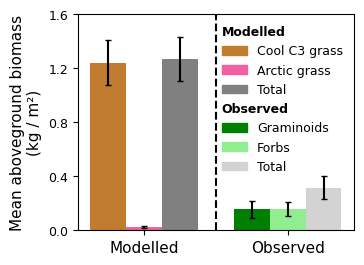

In [52]:
# Instantiate plot
fig, ax = plt.subplots(figsize=FIG_SIZE_CM, dpi=DPI)
width = 0.25  # the width of the bars

labels = ["Modelled", "Observed"]
label_indices = list(range(len(labels)))

# Indices for bar plot positions
indices_first = [x for x in range(len(plot_biomass_df.index)) if x%(len(plot_biomass_df.index)/len(labels))==0]
indices_second = [x+1 for x in indices_first]
indices_third = [x+2 for x in indices_first]

# Custom colors, colorblind friendly ESRI color ramp "Circling circus"
color_model_c3 = "#c27c30"
color_model_arctic = "#f260a1"
color_model_total = "#808080"

# Green colors for forbs and graminoids
color_obs_graminoid = "green"
color_obs_forb = "lightgreen"
color_obs_total = "#D3D3D3"

# First bars in groups of 3
rects1 = ax.bar([x - width for x in label_indices], 
                plot_biomass_df['biomass'][indices_first],
                yerr=plot_biomass_df['sd'][indices_first],
                capsize=2,
                width=width,
                color=[color_model_c3 if plot_biomass_df['origin'][x]=="modelled" else color_obs_graminoid for x in indices_first]
               )
# Second bars in groups of 3
rects2 = ax.bar(label_indices, 
                plot_biomass_df['biomass'][indices_second],
                yerr=plot_biomass_df['sd'][indices_second],
                capsize=2,
                width=width,
                color=[color_model_arctic if plot_biomass_df['origin'][x]=="modelled" else color_obs_forb for x in indices_second]
               )
# Third bars in groups of 3
rects3 = ax.bar([x + width for x in label_indices], 
                plot_biomass_df['biomass'][indices_third],
                yerr=plot_biomass_df['sd'][indices_third],
                capsize=2,
                width=width,
                color=[color_model_total if plot_biomass_df['origin'][x]=="modelled" else color_obs_total for x in indices_second]
               )

ax.set_xticks(list(range(len(labels))), labels)
ax.set_ylabel("Mean aboveground biomass\n(kg / m²)", fontsize=AX_LABEL_FONT_SIZE)

ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.tick_params(axis='x', which='major', labelsize=AX_LABEL_FONT_SIZE)

ax.axvline(x=0.5,
           color="black",
           linestyle="dashed"
          )

"""
Legend handling, add legend subtitles
Adapted from: https://stackoverflow.com/questions/38463369/subtitles-within-matplotlib-legend
"""
import matplotlib.text as mtext
import matplotlib.patches as mpatches

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title
    

# Create custom patches with same color as bars
model_c3_patch = mpatches.Patch(color=color_model_c3, label='C3 grass')
model_arctic_patch = mpatches.Patch(color=color_model_arctic, label='Arctic grass')
model_total_patch = mpatches.Patch(color=color_model_total, label='Total')

obs_graminoid_patch = mpatches.Patch(color=color_obs_graminoid, label='Graminoids')
obs_forb_patch = mpatches.Patch(color=color_obs_forb, label='Forbs')
obs_total_patch = mpatches.Patch(color=color_obs_total, label='Total')

modelled_legend_labels = ['Cool C3 grass', 'Arctic grass', 'Total']
observed_legend_labels = ['Graminoids', 'Forbs', 'Total']

# Add legend
ax.legend(
    ['Modelled'] + [model_c3_patch, model_arctic_patch, model_total_patch] + ['Observed'] + [obs_graminoid_patch, obs_forb_patch, obs_total_patch],
    [''] + modelled_legend_labels + [''] + observed_legend_labels,
    handler_map={str: LegendTitle({
        'fontsize': TICK_LABEL_FONT_SIZE,
        'fontweight': 'demibold'
    })},
    loc='best',
    fontsize=TICK_LABEL_FONT_SIZE,
    frameon=False
)

# Manually set y-ticks
max_y = max(ax.get_yticks())
ax.set_yticks([0, max_y*(1/4), max_y*(2/4), max_y*(3/4), max_y])

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/mod_vs_obs_grass_biomass.png", format='png')

---
## Modelled carbon fluxes
Subset variables from model output related to carbon fluxes. Resample to annual values.

In [47]:
c_flux_var_names = [
    "FATES_GPP",
    "FATES_AUTORESP",
    "FATES_HET_RESP",
    "FATES_NEP"
]

c_flux_vars = [grasspft_model_out_data[name] for name in c_flux_var_names]

In [48]:
# Monthly output, averaged for unit kg C m-2 s-1. To convert to total yearly (kg C m-2 yr-1):
# 1 month on average = 2,628,288 seconds, sum up monthly values
c_flux_vars_annual = [(var*2628288).resample(time='1Y').sum(keep_attrs=True) for var in c_flux_vars]

### Subset last 10 years and create DataFrame.

In [49]:
n_years = 10
# Skip last year
c_fluxes_last_10y = [var.values.flatten()[-n_years-1:-1] for var in c_flux_vars_annual]

In [50]:
# Create DataFrame
c_fluxes_df = pd.DataFrame(columns=[var.name for var in c_flux_vars])

for idx, var in enumerate(c_fluxes_df.columns):
    c_fluxes_df[var] = c_fluxes_last_10y[idx]
    
c_fluxes_df

FATES_GPP  FATES_AUTORESP  FATES_HET_RESP  FATES_NEP
0   2.448402        0.513398        1.593952   0.341052
1   2.310169        0.488738        1.664853   0.156579
2   2.347180        0.502246        1.599228   0.245707
3   2.230328        0.497653        1.496794   0.235881
4   1.986682        0.458888        2.218864  -0.691071
5   1.779419        0.427105        1.876621  -0.524308
6   1.945029        0.451342        1.930694  -0.437007
7   1.978119        0.445116        1.724590  -0.191586
8   2.079200        0.454229        1.597797   0.027174
9   2.188716        0.463277        1.468378   0.257060

### Plot

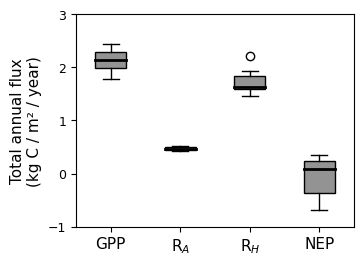

In [51]:
# Instantiate plot
fig, ax = plt.subplots(figsize=FIG_SIZE_CM, dpi=DPI)

box_plot = ax.boxplot(
    c_fluxes_df,
    patch_artist=True,
    medianprops = {
        'linewidth': 2,
        'color': 'black'
    }
)

box_color = '#28282B80'
for patch in box_plot['boxes']:
    patch.set_facecolor(box_color)

x_labels = [
    "GPP",
    r"R$_{A}$",
    r"R$_{H}$",
    "NEP"
]

ax.set_xticklabels(x_labels, fontsize=AX_LABEL_FONT_SIZE-1)
ax.set_ylabel("Total annual flux\n(kg C / m² / year)", fontsize=AX_LABEL_FONT_SIZE)

ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_FONT_SIZE)
ax.tick_params(axis='x', which='major', labelsize=AX_LABEL_FONT_SIZE)

# Manually set y-ticks
max_y = max(ax.get_yticks())
min_y = min(ax.get_yticks())
ax.set_yticks(np.linspace(min_y, max_y, num=5))

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/modelled_c_fluxes.png", format='png')